In [98]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from matplotlib.pyplot import hist
from scipy import stats
# import more functions or modules if you need them !!

In [99]:
# set random seed for numpy
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [100]:
# read in the dataframe
oil_df = pd.read_pickle('../Data/data/comprehensive_new_full.pkl')

In [101]:
oil_df

,year,numcode,oilreserves_full,oilreserves,oilreserves_public,newdiscovery_aspo,aspo,wildcat,endowment,pop_maddison,...,valoilres_public_binarize,oilpop_diff,oilpop_binarize,valoilres_impute_diff,valoilres_impute_binarize,oilpop_impute_diff,oilpop_impute_binarize,crude1990P_diff,milexp_pergdpSIPRI_diff,newdiscovery_aspo_binarize
0,1929.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1930.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1931.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.401178,NaN,NaN
3,1932.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.492896,NaN,NaN
4,1933.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.188141,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17915,2004.0,894,0.00001,NaN,0.00001,NaN,NaN,NaN,0.00001,10962.026367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.292683,NaN,NaN
17916,2005.0,894,0.00001,NaN,0.00001,NaN,NaN,NaN,0.00001,11115.380859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378049,NaN,NaN
17917,2006.0,894,0.00001,NaN,0.00001,NaN,NaN,NaN,0.00001,11288.252930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157455,NaN,NaN
17918,2007.0,894,0.00001,NaN,0.00001,NaN,NaN,NaN,0.00001,11477.447266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080496,NaN,NaN


In [102]:
oil_df.columns

Index(['year', 'numcode', 'oilreserves_full', 'oilreserves',
       'oilreserves_public', 'newdiscovery_aspo', 'aspo', 'wildcat',
       'endowment', 'pop_maddison',
       ...
       'valoilres_public_binarize', 'oilpop_diff', 'oilpop_binarize',
       'valoilres_impute_diff', 'valoilres_impute_binarize',
       'oilpop_impute_diff', 'oilpop_impute_binarize', 'crude1990P_diff',
       'milexp_pergdpSIPRI_diff', 'newdiscovery_aspo_binarize'],
      dtype='object', length=119)

In [103]:
# ATT and ATE AIPTW
def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
    """
    Double ML estimator for the ATT
    This uses the ATT specific scores, see equation 3.9 of https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf
    Return: aiptw of ATE and its standard error
    """
    
    # number of observations
    n = Y.shape[0]
    
    # estimate marginal probability of treatment
    if prob_t is None:
        prob_t = A.mean() 
    
    # att aiptw
    tau_hat = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0)).mean()/ prob_t
  
    # influence curve and standard error of aiptw
    phi = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0) - tau_hat*A) / prob_t
    std_hat = np.std(phi) / np.sqrt(n)

    return tau_hat, std_hat

def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
    """
    Double ML estimator for the ATE
    Return: aiptw of ATE and its standard error
    """
    # number of observations
    n = Y.shape[0]
    
    # ate aiptw
    tau_hat = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g)).mean()
  
    # influence curve and standard error of aiptw
    phi = Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g) - tau_hat   
    std_hat = np.std(phi) / np.sqrt(n)

    return tau_hat, std_hat

In [104]:
# Conditional outcome models (Q models)
def make_linear_Q_model():
    ''' A function that returns a linear q model for later use in k-folding'''
    return LinearRegression()

def make_Q_model(output_type:str):
    ''' A function that returns a general ML q model for later use in k-folding'''
    if output_type == 'binary':
        return RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)
    return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)
# One example: RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)

In [105]:
# Propensity score models (g models)
def make_g_model():
    ''' A function that returns a g model for computing propensity scores'''
    return RandomForestClassifier(n_estimators=100, max_depth=5)
# One example: RandomForestClassifier(n_estimators=100, max_depth=5)

In [106]:
# Functions for K-fold cross-fitting
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    '''
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    '''

    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
        X_train = X.loc[train_index]
        A_train = A.loc[train_index]
        g = make_model()
        g.fit(X_train, A_train)

        # get predictions for split
        predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]
    
    # sanity check that overlap holds
    assert np.isnan(predictions).sum() == 0
    return predictions

def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"
    '''

    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model(output_type)
        q.fit(X_train, y_train)

        if output_type =='binary':
            predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
            predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
        elif output_type == 'continuous':
            predictions0[test_index] = q.predict(X0.loc[test_index])
            predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [108]:
# set variables of interest
outcome = 'onset2COWCS'
treatment = 'valoilres_binarize'
confounders = ['crude1990P_diff',
               'wildcat_diff',
               'out_regdisaster_diff',
               'ecgrowth',
               'pop_maddison_diff',
               'popdens_diff',
               'democracy_diff',
               'logmountain',
               'ethnic_fractionalization',
               'religion_fractionalization',
               'language_fractionalization',
               'leg_british',
               'decade',
               'opec']

In [109]:
def fit_and_run_model(df, outcome:str, treatment:str, confounders:list, make_g_model,
                      make_Q_model, n_splits=5, output_type='binary', ate=True):
    '''
    Function that creates a g, q, and aiptw model based on the 
    given inputs
    
    Inputs: df (pandas df) - the dataframe the variables are contained in
            outcome (str) - the outcome variable
            treatment (str) - the treatment variable
            confounders (lst) - a list of the confounding variables
            make_g_model - the make_g_model function
            make_Q_model - the make_Q_model function
            n_splits (int) - number of splits for the model
            output_type (str) - the desired output type, either binary or continous
            ate (bool) - whether to use ate or alternative att
    
    Returns: tau_hat - the tau hat estimator for the average treatment effect
             std of tau_hat - the standard deviation for the tau_hat estimator
    '''
    df = df.replace({outcome: .00001}, 0)
    df = df[[outcome] + confounders + [treatment]]
    df = df.dropna().reset_index()
    print('Running models for treatment {} and outcome {} on {} samples'.format(treatment, outcome, len(df)))

    outcome = df[outcome]
    confounders = df[confounders]
    treatment = df[treatment]
    treatment = treatment.replace({0.0: 0, 1.0: 1})
    outcome = outcome.replace({0.0: 0, 1.0: 1})
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=n_splits)
    drop=False
    if min(g) < .01:
        print('\nWARNING:\n Some propensity scores are very small,\n which could '
              'lead to an inflated AIPTW.\n Minimum score = ', min(g))
    if max(g) > .99:
        print('\nWARNING:\n Some propensity scores are very large,\n which could '
              'lead to an inflated AIPTW.\n Maximum score = ', max(g))
        drop = True
    print('G Model has been fit')

    Q0_ml, Q1_ml = outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, \
                                                  n_splits=n_splits, output_type=output_type)
    
    print('Q model has been fit')
    data_and_nuisance_estimates_ml = pd.DataFrame({'g': g, 'Q0': Q0_ml, 'Q1': Q1_ml, 'A': treatment, 'Y': outcome})
    
    if drop:
        data_and_nuisance_estimates_ml = data_and_nuisance_estimates_ml[data_and_nuisance_estimates_ml['g'] > .01]
        data_and_nuisance_estimates_ml = data_and_nuisance_estimates_ml[data_and_nuisance_estimates_ml['g'] < .99]
        print('Dropped {} observations due to overlap condition'.format(len(df) - len(data_and_nuisance_estimates_ml)))
    n = len(data_and_nuisance_estimates_ml)
    # ate aiptw
    if ate:
        tau_hat, std_hat = ate_aiptw(**data_and_nuisance_estimates_ml)
    else: 
        tau_hat, std_hat = att_aiptw(**data_and_nuisance_estimates_ml)
    test_stat = tau_hat / std_hat
    p_value = stats.t.sf(abs(test_stat), df=(n-1))
    print('AIPTW model has been fit. Returning \u03C4 hat and its standard deviation')
    print('\u03C4 hat = {}, std = {}, test statistic = {}, p-value = {}\n'.format(round(tau_hat, 5), round(std_hat, 5), round(test_stat, 5), round(p_value, 5)))
    return tau_hat, std_hat, test_stat, p_value

In [180]:
def fit_and_run_model_democracy(df, outcome:str, treatment:str, confounders:list, make_g_model,
                                make_Q_model, n_splits=5, output_type='binary', ate=True):
    '''
    Function that creates a g, q, and aiptw model based on the 
    given inputs
    
    Inputs: df (pandas df) - the dataframe the variables are contained in
            outcome (str) - the outcome variable
            treatment (str) - the treatment variable
            confounders (lst) - a list of the confounding variables
            make_g_model - the make_g_model function
            make_Q_model - the make_Q_model function
            n_splits (int) - number of splits for the model
            output_type (str) - the desired output type, either binary or continous
            ate (bool) - whether to use ate or alternative att
    
    Returns: tau_hat - the tau hat estimator for the average treatment effect
             std of tau_hat - the standard deviation for the tau_hat estimator
    '''
    df = df.replace({outcome: .00001}, 0)
    df = df[[outcome] + confounders + [treatment] + ['democracy']]
    df = df.dropna().reset_index()
    print('Running models for treatment {} and outcome {} on {} samples'.format(treatment, outcome, len(df)))

    outcome = df[outcome]
    confounders = df[confounders]
    treatment = df[treatment]
    democracy = df['democracy']
    treatment = treatment.replace({0.0: 0, 1.0: 1})
    outcome = outcome.replace({0.0: 0, 1.0: 1})
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=n_splits)
    drop=False
    if min(g) < .01:
        print('\nWARNING:\n Some propensity scores are very small,\n which could '
              'lead to an inflated AIPTW.\n Minimum score = ', min(g))
    if max(g) > .99:
        print('\nWARNING:\n Some propensity scores are very large,\n which could '
              'lead to an inflated AIPTW.\n Maximum score = ', max(g))
        drop = True
    print('G Model has been fit')

    Q0_ml, Q1_ml = outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, \
                                                  n_splits=n_splits, output_type=output_type)
    
    print('Q model has been fit')
    data_and_nuisance_estimates_ml = pd.DataFrame({'g': g, 'Q0': Q0_ml, 'Q1': Q1_ml, 'A': treatment, 'Y': outcome})
    
    if drop:
        data_and_nuisance_estimates_ml = data_and_nuisance_estimates_ml[data_and_nuisance_estimates_ml['g'] > .01]
        data_and_nuisance_estimates_ml = data_and_nuisance_estimates_ml[data_and_nuisance_estimates_ml['g'] < .99]
        print('Dropped {} observations due to overlap condition'.format(len(df) - len(data_and_nuisance_estimates_ml)))
        
    democracy = democracy.loc[data_and_nuisance_estimates_ml.index]
    n = len(data_and_nuisance_estimates_ml)
    data_and_nuisance_estimates_ml_demo = data_and_nuisance_estimates_ml.loc[democracy[democracy > .005].index]
    data_and_nuisance_estimates_ml_nondemo = data_and_nuisance_estimates_ml.loc[democracy[democracy <= .005].index]
    # ate aiptw
    tau_hat_demo, std_hat_demo = ate_aiptw(**data_and_nuisance_estimates_ml_demo)
    tau_hat_nondemo, std_hat_nondemo = att_aiptw(**data_and_nuisance_estimates_ml_nondemo)

    test_stat_demo = tau_hat_demo / std_hat_demo
    p_value_demo = stats.t.sf(abs(test_stat_demo), df=(len(data_and_nuisance_estimates_ml_demo)-1))

    test_stat_nondemo = tau_hat_nondemo / std_hat_nondemo
    p_value_nondemo = stats.t.sf(abs(test_stat_nondemo), df=(len(data_and_nuisance_estimates_ml_nondemo)-1))
    #print('AIPTW model has been fit. Returning \u03C4 hat and its standard deviation')
    #print('\u03C4 hat = {}, std = {}, test statistic = {}, p-value = {}\n'.format(round(tau_hat, 5), round(std_hat, 5), round(test_stat, 5), round(p_value, 5)))
    return tau_hat_demo, std_hat_demo, test_stat_demo, p_value_demo, tau_hat_nondemo, std_hat_nondemo, test_stat_nondemo, p_value_nondemo


In [110]:
treatment_lst = ['valoilres_binarize', # value of oil reserves
               'valoilres_public_binarize', # value of oil reserves from public data
               'oilpop_binarize', # oil reserves per capita in million barrels per 1000 persons
               'valoilres_impute_binarize', # value of oilpop_impute (multiply by crude oil price)
               'oilpop_impute_binarize']

outcome_lst = ['onset2COWCS',
               'onsetUCS',
               'coup',
               'periregular',
               'milexp_pergdpSIPRI_diff']

In [111]:
oil_df = oil_df.T.drop_duplicates().T

In [112]:
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [113]:
def make_xgboost_g_model():
    return XGBClassifier(n_estimators=50, max_depth=3)

def make_xgboost_Q_model(output_type:str):
    if output_type == 'binary':
        return XGBClassifier(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)
    return XGBRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)

In [114]:
oil_df[confounders] = oil_df[confounders].astype(float)

In [115]:
df_dict = {'model': [], 'treatment': [], 'outcome': [], 'tau_hat': [], 'tau_std': [], 'test_stat': [], 'p_value': []}
for treat in treatment_lst:
    for out in outcome_lst:
        for model_type in ['rf', 'xgb']:
            if len(oil_df[out].value_counts()) == 2:
                output = 'binary'
            else:
                output = 'continuous'
            if model_type == 'rf':
                tau_hat, tau_std, test_stat, p_value = fit_and_run_model(oil_df, out, treat, confounders, make_g_model, make_Q_model, output_type=output, ate=False)
            else:
                tau_hat, tau_std, test_stat, p_value = fit_and_run_model(oil_df, out, treat, confounders, make_xgboost_g_model, make_xgboost_Q_model, output_type=output, ate=False)
            df_dict['model'].append(model_type)
            df_dict['treatment'].append(treat)
            df_dict['outcome'].append(out)
            df_dict['tau_hat'].append(tau_hat)
            df_dict['tau_std'].append(tau_std)
            df_dict['test_stat'].append(test_stat)
            df_dict['p_value'].append(p_value)

att_results_df = pd.DataFrame(data=df_dict)

Running models for treatment valoilres_binarize and outcome onset2COWCS on 5174 samples
G Model has been fit
Q model has been fit
AIPTW model has been fit. Returning τ hat and its standard deviation
τ hat = -9e-05, std = 0.00484, test statistic = -0.01917, p-value = 0.49235

Running models for treatment valoilres_binarize and outcome onset2COWCS on 5174 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  0.00016930692072492093

 Some propensity scores are very large,
 which could lead to an inflated AIPTW.
 Maximum score =  0.9984782338142395
G Model has been fit
Q model has been fit
Dropped 1645 observations due to overlap condition
AIPTW model has been fit. Returning τ hat and its standard deviation
τ hat = -0.00882, std = 0.01667, test statistic = -0.52921, p-value = 0.29834

Running models for treatment valoilres_binarize and outcome onsetUCS on 4517 samples
G Model has been fit
Q model has been fit
AIPTW model has been fit. Re


 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  0.00010648815805325285

 Some propensity scores are very large,
 which could lead to an inflated AIPTW.
 Maximum score =  0.994769275188446
G Model has been fit
Q model has been fit
Dropped 565 observations due to overlap condition
AIPTW model has been fit. Returning τ hat and its standard deviation
τ hat = 0.5545, std = 0.36618, test statistic = 1.51427, p-value = 0.0651

Running models for treatment oilpop_binarize and outcome onset2COWCS on 5174 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  0.004113149545574649
G Model has been fit
Q model has been fit
AIPTW model has been fit. Returning τ hat and its standard deviation
τ hat = -0.00181, std = 0.00682, test statistic = -0.2655, p-value = 0.39532

Running models for treatment oilpop_binarize and outcome onset2COWCS on 5174 samples

 Some propensity scores are very small,
 whic

Q model has been fit
AIPTW model has been fit. Returning τ hat and its standard deviation
τ hat = 0.53593, std = 0.41176, test statistic = 1.30157, p-value = 0.09665

Running models for treatment valoilres_impute_binarize and outcome milexp_pergdpSIPRI_diff on 1302 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  7.458581239916384e-05

 Some propensity scores are very large,
 which could lead to an inflated AIPTW.
 Maximum score =  0.9979853630065918
G Model has been fit
Q model has been fit
Dropped 787 observations due to overlap condition
AIPTW model has been fit. Returning τ hat and its standard deviation
τ hat = 0.09476, std = 0.12696, test statistic = 0.74642, p-value = 0.22777

Running models for treatment oilpop_impute_binarize and outcome onset2COWCS on 5174 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  0.005810174146911319
G Model has been fit
Q model has been

In [116]:
att_results_df

,model,treatment,outcome,tau_hat,tau_std,test_stat,p_value
0,rf,valoilres_binarize,onset2COWCS,-0.000093,0.004841,-0.019169,0.492354
1,xgb,valoilres_binarize,onset2COWCS,-0.008819,0.016666,-0.529206,0.298343
2,rf,valoilres_binarize,onsetUCS,-0.001373,0.008469,-0.162126,0.435607
3,xgb,valoilres_binarize,onsetUCS,-0.038175,0.080767,-0.472653,0.318242
4,rf,valoilres_binarize,coup,-0.024780,0.012849,-1.928501,0.026924
5,xgb,valoilres_binarize,coup,0.139695,0.107302,1.301880,0.096508
6,rf,valoilres_binarize,periregular,-0.013310,0.005828,-2.283614,0.011229
7,xgb,valoilres_binarize,periregular,-0.005801,0.012502,-0.463972,0.321349
8,rf,valoilres_binarize,milexp_pergdpSIPRI_diff,0.532218,0.411386,1.293718,0.097996
9,xgb,valoilres_binarize,milexp_pergdpSIPRI_diff,0.094764,0.126958,0.746423,0.227773


In [134]:
att_results_df.loc[[0, 1, 4, 5, 6, 7, 12, 13, 26, 27, 30, 31], :].sort_values(by=['outcome', 'treatment', 'model']).reset_index(drop=True)

,model,treatment,outcome,tau_hat,tau_std,test_stat,p_value
0,rf,valoilres_binarize,coup,-0.024780,0.012849,-1.928501,0.026924
1,xgb,valoilres_binarize,coup,0.139695,0.107302,1.301880,0.096508
2,rf,valoilres_binarize,onset2COWCS,-0.000093,0.004841,-0.019169,0.492354
3,xgb,valoilres_binarize,onset2COWCS,-0.008819,0.016666,-0.529206,0.298343
4,rf,valoilres_impute_binarize,onset2COWCS,0.000938,0.004504,0.208254,0.417519
5,xgb,valoilres_impute_binarize,onset2COWCS,0.005646,0.005395,1.046495,0.147691
6,rf,valoilres_public_binarize,onsetUCS,0.014194,0.008519,1.666199,0.047876
7,xgb,valoilres_public_binarize,onsetUCS,0.009038,0.022647,0.399076,0.344929
8,rf,oilpop_binarize,periregular,-0.003430,0.006842,-0.501310,0.308093
9,xgb,oilpop_binarize,periregular,-0.003504,0.010732,-0.326511,0.372029


In [137]:
att_temp = att_results_df[(att_results_df['treatment'] == 'valoilres_binarize') | (att_results_df['treatment'] == 'oilpop_binarize')].reset_index(drop=True)

In [143]:
att_temp[att_temp['outcome'].isin(['onset2COWCS', 'coup', 'periregular', 'milexp_pergdpSIPRI_diff'])].sort_values(by=['outcome', 'treatment', 'model']).reset_index(drop=True)

,model,treatment,outcome,tau_hat,tau_std,test_stat,p_value
0,rf,oilpop_binarize,coup,-0.022034,0.021585,-1.020779,0.153704
1,xgb,oilpop_binarize,coup,-0.048128,0.027503,-1.749916,0.040097
2,rf,valoilres_binarize,coup,-0.024780,0.012849,-1.928501,0.026924
3,xgb,valoilres_binarize,coup,0.139695,0.107302,1.301880,0.096508
4,rf,oilpop_binarize,milexp_pergdpSIPRI_diff,3.326232,2.931039,1.134830,0.128328
5,xgb,oilpop_binarize,milexp_pergdpSIPRI_diff,3.740208,2.976707,1.256492,0.104582
6,rf,valoilres_binarize,milexp_pergdpSIPRI_diff,0.532218,0.411386,1.293718,0.097996
7,xgb,valoilres_binarize,milexp_pergdpSIPRI_diff,0.094764,0.126958,0.746423,0.227773
8,rf,oilpop_binarize,onset2COWCS,-0.001811,0.006821,-0.265501,0.395317
9,xgb,oilpop_binarize,onset2COWCS,-0.001714,0.007948,-0.215610,0.414650


In [117]:
att_results_df[att_results_df['p_value'] < .05]

,model,treatment,outcome,tau_hat,tau_std,test_stat,p_value
4,rf,valoilres_binarize,coup,-0.024780,0.012849,-1.928501,0.026924
6,rf,valoilres_binarize,periregular,-0.013310,0.005828,-2.283614,0.011229
11,xgb,valoilres_public_binarize,onset2COWCS,0.010381,0.005081,2.043252,0.020545
12,rf,valoilres_public_binarize,onsetUCS,0.014194,0.008519,1.666199,0.047876
25,xgb,oilpop_binarize,coup,-0.048128,0.027503,-1.749916,0.040097
36,rf,valoilres_impute_binarize,periregular,-0.012925,0.005818,-2.221473,0.013193


In [118]:
treatment_lst = ['newdiscovery_aspo_binarize']
outcome_lst = ['d2incidenceU',
               'd3_6incidenceU',
               'onset2COWCS',
               'onsetUCS',
               'coup',
               'periregular',
               'milexp_pergdpSIPRI_diff']
confounders = ['crude1990P_diff',
               'wildcat_diff',
               'out_regdisaster_diff',
               'ecgrowth',
               'pop_maddison_diff',
               'popdens_diff',
               'democracy_diff',
               'logmountain',
               'ethnic_fractionalization',
               'religion_fractionalization',
               'language_fractionalization',
               'leg_british',
               'decade',
               'opec']

In [119]:
df_dict = {'model': [], 'treatment': [], 'outcome': [], 'tau_hat': [], 'tau_std': [], 'test_stat': [], 'p_value': []}
for treat in treatment_lst:
    for out in outcome_lst:
        for model_type in ['rf', 'xgb']:
            if len(oil_df[out].value_counts()) == 2:
                output = 'binary'
            else:
                output = 'continuous'
            if model_type == 'rf':
                tau_hat, tau_std, test_stat, p_value = fit_and_run_model(oil_df, out, treat, confounders, make_g_model, make_Q_model, output_type=output, ate=False)
            else:
                tau_hat, tau_std, test_stat, p_value = fit_and_run_model(oil_df, out, treat, confounders, make_xgboost_g_model, make_xgboost_Q_model, output_type=output, ate=False)
            df_dict['model'].append(model_type)
            df_dict['treatment'].append(treat)
            df_dict['outcome'].append(out)
            df_dict['tau_hat'].append(tau_hat)
            df_dict['tau_std'].append(tau_std)
            df_dict['test_stat'].append(test_stat)
            df_dict['p_value'].append(p_value)

att_discovery_results_df = pd.DataFrame(data=df_dict)

Running models for treatment newdiscovery_aspo_binarize and outcome d2incidenceU on 2561 samples
G Model has been fit
Q model has been fit
AIPTW model has been fit. Returning τ hat and its standard deviation
τ hat = 0.00204, std = 0.01281, test statistic = 0.15951, p-value = 0.43664

Running models for treatment newdiscovery_aspo_binarize and outcome d2incidenceU on 2561 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  0.004560614470392466

 Some propensity scores are very large,
 which could lead to an inflated AIPTW.
 Maximum score =  0.9953548908233643
G Model has been fit
Q model has been fit
Dropped 18 observations due to overlap condition
AIPTW model has been fit. Returning τ hat and its standard deviation
τ hat = -0.01818, std = 0.02404, test statistic = -0.75605, p-value = 0.22484

Running models for treatment newdiscovery_aspo_binarize and outcome d3_6incidenceU on 2509 samples
G Model has been fit
Q model has been fit


In [147]:
att_discovery_results_df

,model,treatment,outcome,tau_hat,tau_std,test_stat,p_value
0,rf,newdiscovery_aspo_binarize,d2incidenceU,0.002043,0.012810,0.159511,0.436639
1,xgb,newdiscovery_aspo_binarize,d2incidenceU,-0.018176,0.024041,-0.756049,0.224845
2,rf,newdiscovery_aspo_binarize,d3_6incidenceU,-0.007179,0.015563,-0.461279,0.322319
3,xgb,newdiscovery_aspo_binarize,d3_6incidenceU,0.000975,0.037087,0.026291,0.489514
4,rf,newdiscovery_aspo_binarize,onset2COWCS,0.004785,0.003634,1.316723,0.093996
5,xgb,newdiscovery_aspo_binarize,onset2COWCS,0.004747,0.006410,0.740534,0.229505
6,rf,newdiscovery_aspo_binarize,onsetUCS,0.007407,0.006296,1.176422,0.119746
7,xgb,newdiscovery_aspo_binarize,onsetUCS,0.007837,0.014530,0.539333,0.294843
8,rf,newdiscovery_aspo_binarize,coup,-0.036988,0.009984,-3.704788,0.000107
9,xgb,newdiscovery_aspo_binarize,coup,-0.010155,0.023975,-0.423549,0.335957


In [146]:
att_discovery_results_df.loc[0:3, :]

,model,treatment,outcome,tau_hat,tau_std,test_stat,p_value
0,rf,newdiscovery_aspo_binarize,d2incidenceU,0.002043,0.012810,0.159511,0.436639
1,xgb,newdiscovery_aspo_binarize,d2incidenceU,-0.018176,0.024041,-0.756049,0.224845
2,rf,newdiscovery_aspo_binarize,d3_6incidenceU,-0.007179,0.015563,-0.461279,0.322319
3,xgb,newdiscovery_aspo_binarize,d3_6incidenceU,0.000975,0.037087,0.026291,0.489514


In [121]:
g_df = oil_df[confounders + [treatment]].dropna().reset_index()
g_df[treatment] = g_df[treatment].replace({0.0: 0, 1.0: 1})
rf_propensity = treatment_k_fold_fit_and_predict(make_g_model, g_df[confounders], g_df[treatment], n_splits=5)
xgb_propensity = treatment_k_fold_fit_and_predict(make_xgboost_g_model, g_df[confounders], g_df[treatment], n_splits=5)

In [122]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

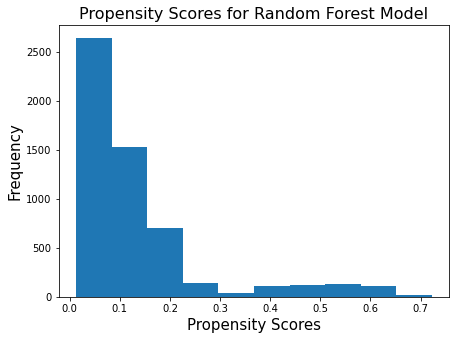

In [123]:
plt.figure(figsize=(7, 5))
hist(rf_propensity)
plt.title('Propensity Scores for Random Forest Model', fontsize=16)
plt.xlabel('Propensity Scores', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

In [153]:
rf_propensity[rf_propensity < .05]

array([0.03240828, 0.0364236 , 0.02938638, ..., 0.02414552, 0.04922653,
       0.04654305])

Text(0, 0.5, 'Frequency')

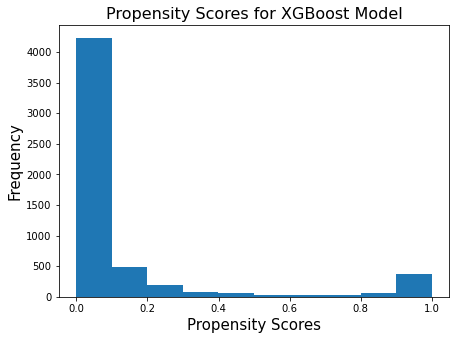

In [124]:
plt.figure(figsize=(7, 5))
hist(xgb_propensity)
plt.title('Propensity Scores for XGBoost Model', fontsize=16)
plt.xlabel('Propensity Scores', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

In [186]:
treatment_lst = ['valoilres_binarize', # value of oil reserves
               'valoilres_public_binarize', # value of oil reserves from public data
               'oilpop_binarize', # oil reserves per capita in million barrels per 1000 persons
               'valoilres_impute_binarize', # value of oilpop_impute (multiply by crude oil price)
               'oilpop_impute_binarize']

outcome_lst = ['onset2COWCS',
               'onsetUCS',
               'coup',
               'periregular',
               'milexp_pergdpSIPRI_diff']
confounders = ['crude1990P_diff',
               'wildcat_diff',
               'out_regdisaster_diff',
               'ecgrowth',
               'pop_maddison_diff',
               'popdens_diff',
               'democracy_diff',
               'logmountain',
               'ethnic_fractionalization',
               'religion_fractionalization',
               'language_fractionalization',
               'leg_british',
               'decade',
               'opec']

In [187]:
df_dict = {'model': [], 'democracy': [], 'treatment': [], 'outcome': [], 'tau_hat': [], 'tau_std': [], 'test_stat': [], 'p_value': []}
for treat in treatment_lst:
    for out in outcome_lst:
        for model_type in ['rf', 'xgb']:
            if len(oil_df[out].value_counts()) == 2:
                output = 'binary'
            else:
                output = 'continuous'
            if model_type == 'rf':
                tau_hat_demo, std_hat_demo, test_stat_demo, p_value_demo, tau_hat_nondemo, std_hat_nondemo, test_stat_nondemo, p_value_nondemo = fit_and_run_model_democracy(oil_df, out, treat, confounders, make_g_model, make_Q_model, output_type=output, ate=False)
            else:
                tau_hat_demo, std_hat_demo, test_stat_demo, p_value_demo, tau_hat_nondemo, std_hat_nondemo, test_stat_nondemo, p_value_nondemo = fit_and_run_model_democracy(oil_df, out, treat, confounders, make_xgboost_g_model, make_xgboost_Q_model, output_type=output, ate=False)
            df_dict['model'].append(model_type)
            df_dict['democracy'].append('demo')
            df_dict['treatment'].append(treat)
            df_dict['outcome'].append(out)
            df_dict['tau_hat'].append(tau_hat_demo)
            df_dict['tau_std'].append(std_hat_demo)
            df_dict['test_stat'].append(test_stat_demo)
            df_dict['p_value'].append(p_value_demo)
            df_dict['model'].append(model_type)
            df_dict['democracy'].append('nondemo')
            df_dict['treatment'].append(treat)
            df_dict['outcome'].append(out)
            df_dict['tau_hat'].append(tau_hat_nondemo)
            df_dict['tau_std'].append(std_hat_nondemo)
            df_dict['test_stat'].append(test_stat_nondemo)
            df_dict['p_value'].append(p_value_nondemo)

att_democracy_results_df = pd.DataFrame(data=df_dict)

Running models for treatment valoilres_binarize and outcome onset2COWCS on 5124 samples
G Model has been fit
Q model has been fit
Running models for treatment valoilres_binarize and outcome onset2COWCS on 5124 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  0.0001718762650853023

 Some propensity scores are very large,
 which could lead to an inflated AIPTW.
 Maximum score =  0.998391330242157
G Model has been fit
Q model has been fit
Dropped 1638 observations due to overlap condition
Running models for treatment valoilres_binarize and outcome onsetUCS on 4491 samples
G Model has been fit
Q model has been fit
Running models for treatment valoilres_binarize and outcome onsetUCS on 4491 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  9.31727554416284e-05

 Some propensity scores are very large,
 which could lead to an inflated AIPTW.
 Maximum score =  0.9991288781166077
G

Q model has been fit
Running models for treatment oilpop_binarize and outcome milexp_pergdpSIPRI_diff on 1288 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  3.679205838125199e-05
G Model has been fit
Q model has been fit
Running models for treatment valoilres_impute_binarize and outcome onset2COWCS on 5124 samples
G Model has been fit
Q model has been fit
Running models for treatment valoilres_impute_binarize and outcome onset2COWCS on 5124 samples

 Some propensity scores are very small,
 which could lead to an inflated AIPTW.
 Minimum score =  0.00014290718536358327

 Some propensity scores are very large,
 which could lead to an inflated AIPTW.
 Maximum score =  0.9986017346382141
G Model has been fit
Q model has been fit
Dropped 1651 observations due to overlap condition
Running models for treatment valoilres_impute_binarize and outcome onsetUCS on 4491 samples
G Model has been fit
Q model has been fit
Running models for t

In [188]:
att_democracy_results_df

,model,democracy,treatment,outcome,tau_hat,tau_std,test_stat,p_value
0,rf,demo,valoilres_binarize,onset2COWCS,-0.000383,0.003071,-0.124660,0.450401
1,rf,nondemo,valoilres_binarize,onset2COWCS,0.003078,0.008852,0.347677,0.364055
2,xgb,demo,valoilres_binarize,onset2COWCS,-0.005328,0.004251,-1.253165,0.105159
3,xgb,nondemo,valoilres_binarize,onset2COWCS,-0.024841,0.039308,-0.631966,0.263745
4,rf,demo,valoilres_binarize,onsetUCS,0.011293,0.008934,1.264042,0.103176
...,...,...,...,...,...,...,...,...
95,xgb,nondemo,oilpop_impute_binarize,periregular,-0.012129,0.017556,-0.690871,0.244866
96,rf,demo,oilpop_impute_binarize,milexp_pergdpSIPRI_diff,0.382090,0.353341,1.081363,0.139929
97,rf,nondemo,oilpop_impute_binarize,milexp_pergdpSIPRI_diff,5.759621,5.417759,1.063100,0.144137
98,xgb,demo,oilpop_impute_binarize,milexp_pergdpSIPRI_diff,7.164805,7.195176,0.995779,0.159828


In [190]:
att_demo_results = att_democracy_results_df[att_democracy_results_df['democracy'] == 'demo']
att_nondemo_results = att_democracy_results_df[att_democracy_results_df['democracy'] == 'nondemo']

In [191]:
att_demo_temp = att_demo_results[(att_demo_results['treatment'] == 'valoilres_binarize') | (att_demo_results['treatment'] == 'oilpop_binarize')].reset_index(drop=True)
att_nondemo_temp = att_nondemo_results[(att_nondemo_results['treatment'] == 'valoilres_binarize') | (att_nondemo_results['treatment'] == 'oilpop_binarize')].reset_index(drop=True)



In [193]:
att_demo_temp[att_demo_temp['outcome'].isin(['onset2COWCS', 'coup', 'periregular', 'milexp_pergdpSIPRI_diff'])].sort_values(by=['outcome', 'treatment', 'model']).reset_index(drop=True).drop('democracy', axis=1)




,model,treatment,outcome,tau_hat,tau_std,test_stat,p_value
0,rf,oilpop_binarize,coup,0.015277,0.015947,0.957995,0.169081
1,xgb,oilpop_binarize,coup,-0.008449,0.029862,-0.282946,0.388621
2,rf,valoilres_binarize,coup,0.011720,0.010239,1.144562,0.126252
3,xgb,valoilres_binarize,coup,0.055809,0.043246,1.290504,0.098531
4,rf,oilpop_binarize,milexp_pergdpSIPRI_diff,0.530314,0.549485,0.965112,0.167389
5,xgb,oilpop_binarize,milexp_pergdpSIPRI_diff,7.164805,7.195176,0.995779,0.159828
6,rf,valoilres_binarize,milexp_pergdpSIPRI_diff,-0.009669,0.022439,-0.430893,0.333331
7,xgb,valoilres_binarize,milexp_pergdpSIPRI_diff,-0.174507,0.086964,-2.006655,0.022823
8,rf,oilpop_binarize,onset2COWCS,-0.007163,0.003660,-1.957094,0.025224
9,xgb,oilpop_binarize,onset2COWCS,-0.023302,0.015872,-1.468144,0.071095


In [194]:
att_nondemo_temp[att_nondemo_temp['outcome'].isin(['onset2COWCS', 'coup', 'periregular', 'milexp_pergdpSIPRI_diff'])].sort_values(by=['outcome', 'treatment', 'model']).reset_index(drop=True).drop('democracy', axis=1)



,model,treatment,outcome,tau_hat,tau_std,test_stat,p_value
0,rf,oilpop_binarize,coup,-0.041599,0.042245,-0.984706,0.162429
1,xgb,oilpop_binarize,coup,-0.057552,0.052347,-1.099439,0.135838
2,rf,valoilres_binarize,coup,-0.024356,0.023339,-1.043578,0.148388
3,xgb,valoilres_binarize,coup,0.015975,0.031459,0.507805,0.305827
4,rf,oilpop_binarize,milexp_pergdpSIPRI_diff,5.824807,5.420014,1.074685,0.141529
5,xgb,oilpop_binarize,milexp_pergdpSIPRI_diff,4.715068,4.793272,0.983685,0.162884
6,rf,valoilres_binarize,milexp_pergdpSIPRI_diff,0.959381,0.937215,1.023651,0.153259
7,xgb,valoilres_binarize,milexp_pergdpSIPRI_diff,1.234342,1.039887,1.186996,0.118315
8,rf,oilpop_binarize,onset2COWCS,0.005086,0.014961,0.339972,0.366952
9,xgb,oilpop_binarize,onset2COWCS,-0.000261,0.018183,-0.014339,0.494280


In [195]:
treatment

'valoilres_binarize'

In [196]:
g_demo_df = oil_df[confounders + [treatment] + ['democracy']][oil_df['democracy'] > .005].dropna().reset_index()
g_demo_df[treatment] = g_demo_df[treatment].replace({0.0: 0, 1.0: 1})
rf_demo_propensity = treatment_k_fold_fit_and_predict(make_g_model, g_demo_df[confounders], g_demo_df[treatment], n_splits=5)
xgb_demo_propensity = treatment_k_fold_fit_and_predict(make_xgboost_g_model, g_demo_df[confounders], g_demo_df[treatment], n_splits=5)

In [197]:
g_nondemo_df = oil_df[confounders + [treatment] + ['democracy']][oil_df['democracy'] <= .005].dropna().reset_index()
g_nondemo_df[treatment] = g_nondemo_df[treatment].replace({0.0: 0, 1.0: 1})
rf_nondemo_propensity = treatment_k_fold_fit_and_predict(make_g_model, g_nondemo_df[confounders], g_nondemo_df[treatment], n_splits=5)
xgb_nondemo_propensity = treatment_k_fold_fit_and_predict(make_xgboost_g_model, g_nondemo_df[confounders], g_nondemo_df[treatment], n_splits=5)

Text(0, 0.5, 'Frequency')

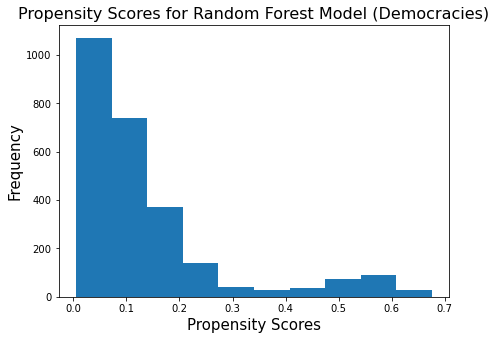

In [199]:
plt.figure(figsize=(7, 5))
hist(rf_demo_propensity)
plt.title('Propensity Scores for Random Forest Model (Democracies)', fontsize=16)
plt.xlabel('Propensity Scores', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

Text(0, 0.5, 'Frequency')

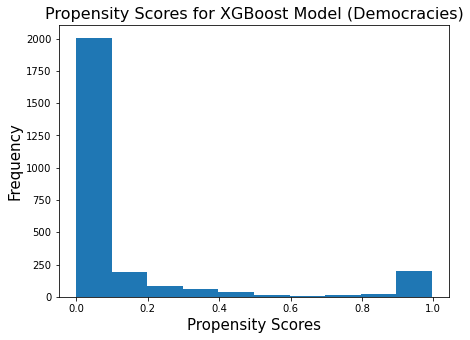

In [198]:
plt.figure(figsize=(7, 5))
hist(xgb_demo_propensity)
plt.title('Propensity Scores for XGBoost Model (Democracies)', fontsize=16)
plt.xlabel('Propensity Scores', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

Text(0, 0.5, 'Frequency')

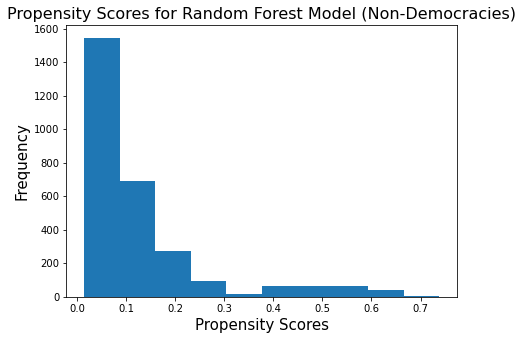

In [201]:
plt.figure(figsize=(7, 5))
hist(rf_nondemo_propensity)
plt.title('Propensity Scores for Random Forest Model (Non-Democracies)', fontsize=16)
plt.xlabel('Propensity Scores', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

Text(0, 0.5, 'Frequency')

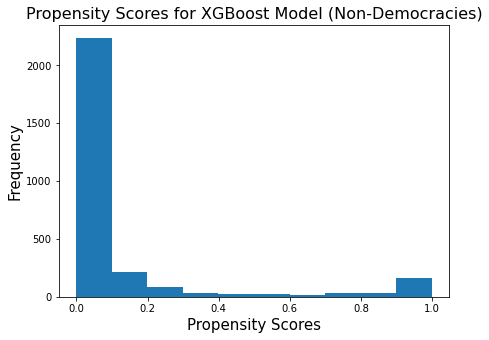

In [202]:
plt.figure(figsize=(7, 5))
hist(xgb_nondemo_propensity)
plt.title('Propensity Scores for XGBoost Model (Non-Democracies)', fontsize=16)
plt.xlabel('Propensity Scores', fontsize=15)
plt.ylabel('Frequency', fontsize=15)